# 卷积神经网络
本章介绍的卷积神经网络（convolutional neural network，CNN）是一类强大的、为处理图像数据而设计的神经网络。 基于卷积神经网络架构的模型在计算机视觉领域中已经占主导地位，当今几乎所有的图像识别、目标检测或语义分割相关的学术竞赛和商业应用都以这种方法为基础。

在本章的开始，我们将介绍构成所有卷积网络主干的基本元素。 这包括卷积层本身、填充（padding）和步幅（stride）的基本细节、用于在相邻区域汇聚信息的汇聚层（pooling）、在每一层中多通道（channel）的使用，以及有关现代卷积网络架构的仔细讨论。

## 从全连接层到卷积

我们之前讨论的多层感知机十分适合处理表格数据，其中行对应样本，列对应特征。 对于表格数据，我们寻找的模式可能涉及特征之间的交互，但是我们不能预先假设任何与特征交互相关的先验结构。 此时，多层感知机可能是最好的选择，然而对于高维感知数据，这种缺少结构的网络可能会变得不实用。

卷积神经网络（convolutional neural networks，CNN）是机器学习利用自然图像中一些已知结构的创造性方法。

### 不变性
1. *平移不变性*（translation invariance）：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。
1. *局部性*（locality）：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。

### 多层感知机的限制
利用不变性，使用全连接演变到卷积：

使用$[\mathbf{X}]_{i, j}$和$[\mathbf{H}]_{i, j}$分别表示输入图像和隐藏表示中位置（$i$,$j$）处的像素。
为了使每个隐藏神经元都能接收到每个输入像素的信息，我们将参数从权重矩阵（如同我们先前在多层感知机中所做的那样）替换为四阶权重张量$\mathsf{W}$。假设$\mathbf{U}$包含偏置参数，我们可以将全连接层形式化地表示为

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

其中，从$\mathsf{W}$到$\mathsf{V}$的转换只是形式上的转换，因为在这两个四阶张量的元素之间存在一一对应的关系。

#### 平移不变性
图像的平移不变性使我们以相同的方式处理局部图像，而不在乎它的位置。也就是说，$\mathsf{V}$和$\mathbf{U}$实际上不依赖于$(i, j)$的值，即$[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$。并且$\mathbf{U}$是一个常数，比如$u$。因此，我们可以简化$\mathbf{H}$定义为：

$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}.$$

这就是*卷积*（convolution）。我们是在使用系数$[\mathbf{V}]_{a, b}$对位置$(i, j)$附近的像素$(i+a, j+b)$进行加权得到$[\mathbf{H}]_{i, j}$。

#### 局部性
局部性意味着计算相应的隐藏表示只需一小部分局部图像像素。如上所述，为了收集用来训练参数$[\mathbf{H}]_{i, j}$的相关信息，我们不应偏离到距$(i, j)$很远的地方。这意味着在$|a|> \Delta$或$|b| > \Delta$的范围之外，我们可以设置$[\mathbf{V}]_{a, b} = 0$。因此，我们可以将$[\mathbf{H}]_{i, j}$重写为

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$


简而言之， 上述是一个*卷积层*（convolutional layer），而卷积神经网络是包含卷积层的一类特殊的神经网络。
在深度学习研究社区中，$\mathbf{V}$被称为*卷积核*（convolution kernel）或者*滤波器*（filter），亦或简单地称之为该卷积层的*权重*，通常该权重是可学习的参数。

 当图像处理的局部区域很小时，卷积神经网络与多层感知机的训练差异可能是巨大的：以前，多层感知机可能需要数十亿个参数来表示网络中的一层，而现在卷积神经网络通常只需要几百个参数，而且不需要改变输入或隐藏表示的维数。

### 卷积
卷积是一种将两个函数结合生成第三个函数的运算，描述了一个函数如何通过另一个函数的翻转和滑动来变化。
在数学中，两个函数（比如$f, g: \mathbb{R}^d \to \mathbb{R}$）之间的“卷积”被定义为

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

也就是说，卷积是当把一个函数“翻转”并移位$\mathbf{x}$时，测量$f$和$g$之间的重叠。
当为离散对象时，积分就变成求和。例如，对于由索引为$\mathbb{Z}$的、平方可和的、无限维向量集合中抽取的向量，我们得到以下定义：

$$(f * g)(i) = \sum_a f(a) g(i-a).$$

对于二维张量，则为$f$的索引$(a, b)$和$g$的索引$(i-a, j-b)$上的对应加和：

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).$$
:eqlabel:`eq_2d-conv-discrete`

### 小结
- 对全连接层使用平移不变性和局部性得到卷积层。
- 在图像处理中，卷积层通常比全连接层需要更少的参数，但依旧获得高效用的模型。
- 卷积神经网络（CNN）是一类特殊的神经网络，它可以包含多个卷积层。

## 图像卷积
卷积神经网络的设计是用于探索图像数据，本节我们将以图像为例。

### 互相关运算

严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是互相关运算（cross-correlation），而不是卷积运算。 根据 6.1节中的描述，在卷积层中，输入张量和核张量通过互相关运算产生输出张量。

首先，我们暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。在 下图中，输入是高度为$3$、宽度为$3$的二维张量（即形状为$3 \times 3$）。卷积核的高度和宽度都是$2$，而卷积核窗口（或卷积窗口）的形状由内核的高度和宽度决定（即$2 \times 2$）。

![二维互相关运算。阴影部分是第一个输出元素，以及用于计算输出的输入张量元素和核张量元素：$0\times0+1\times1+3\times2+4\times3=19$.](http://d2l.ai/_images/correlation.svg)


在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。
当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。
在如上例子中，输出张量的四个元素由二维互相关运算得到，这个输出高度为$2$、宽度为$2$，如下所示：



$$0\times0+1\times1+3\times2+4\times3=19,$$
$$1\times0+2\times1+4\times2+5\times3=25,$$
$$3\times0+4\times1+6\times2+7\times3=37,$$
$$4\times0+5\times1+7\times2+8\times3=43.$$

输出大小等于输入大小$n_h \times n_w$减去卷积核大小$k_h \times k_w$，即：

$$(n_h-k_h+1) \times (n_w-k_w+1).$$


In [2]:
# 我们在corr2d函数中实现如上过程，该函数接受输入张量X和卷积核张量K，并返回输出张量Y。
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 卷积层
卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。 所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。

In [4]:
class Conv2D(nn.Module):
    # weight和bias声明为两个模型参数
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    # 前向传播函数调用corr2d函数并添加偏置。
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

高度和宽度分别为$h$和$w$的卷积核可以被称为$h \times w$卷积或$h \times w$卷积核。

### 图像中目标的边缘检测

如下是[**卷积层的一个简单应用：**]通过找到像素变化的位置，来(**检测图像中不同颜色的边缘**)。

In [5]:
# 构造一个$6\times 8$像素的黑白图像。中间四列为黑色（$0$），其余像素为白色（$1$）。
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

#构造一个高度为$1$、宽度为$2$的卷积核`K`。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。

In [6]:

K = torch.tensor([[1.0, -1.0]])
K

tensor([[ 1., -1.]])

输出`Y`中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘

In [7]:

Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 学习卷积核

上面是通过自己定义的卷积核，我们也可以通过仅查看“输入-输出”对来学习由X生成Y的卷积核。

我们先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们比较Y与卷积层输出的平方误差，然后计算梯度来更新卷积核。

In [9]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # print("conv2d.weight.data:",conv2d.weight.data)
    # print("conv2d.weight.grad:",conv2d.weight.grad)
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

conv2d.weight.data: tensor([[[[-0.4883, -0.4685]]]])
conv2d.weight.grad: tensor([[[[-40.8210, -16.5831]]]])
conv2d.weight.data: tensor([[[[0.7363, 0.0290]]]])
conv2d.weight.grad: tensor([[[[15.2055, 30.7178]]]])
epoch 2, loss 13.800
conv2d.weight.data: tensor([[[[ 0.2802, -0.8925]]]])
conv2d.weight.grad: tensor([[[[-23.3332, -13.4054]]]])
conv2d.weight.data: tensor([[[[ 0.9802, -0.4903]]]])
conv2d.weight.grad: tensor([[[[11.5185, 17.8724]]]])
epoch 4, loss 4.440
conv2d.weight.data: tensor([[[[ 0.6346, -1.0265]]]])
conv2d.weight.grad: tensor([[[[-13.7896,  -9.7231]]]])
conv2d.weight.data: tensor([[[[ 1.0483, -0.7348]]]])
conv2d.weight.grad: tensor([[[[ 8.1038, 10.7063]]]])
epoch 6, loss 1.615
conv2d.weight.data: tensor([[[[ 0.8052, -1.0560]]]])
conv2d.weight.grad: tensor([[[[-8.3569, -6.6912]]]])
conv2d.weight.data: tensor([[[[ 1.0559, -0.8553]]]])
conv2d.weight.grad: tensor([[[[5.4863, 6.5522]]]])
epoch 8, loss 0.628
conv2d.weight.data: tensor([[[[ 0.8913, -1.0518]]]])
conv2d.weight.gr

In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9370, -1.0397]])

上面和我们上面自己定义的非常接近

### 互相关和卷积

互相关和卷积运算，它们差别不大，我们只需水平和垂直翻转二维卷积核张量，然后对输入张量执行互相关运算。由于卷积核是从数据中学习到的，因此无论这些层执行严格的卷积运算还是互相关运算，卷积层的输出都不会受到影响。


### 特征映射和感受野

在互相关运算中，输出的卷积层有时被称为特征映射（feature map），因为它可以被视为一个输入映射到下一层的空间维度的转换器。

在卷积神经网络中，对于某一层的任意元素$x$，其*感受野*（receptive field）是指在前向传播期间可能影响$x$计算的所有元素（来自所有先前层）。

### 小结
* 二维卷积层的核心计算是二维互相关运算。最简单的形式是，对二维输入数据和卷积核执行互相关操作，然后添加一个偏置。
* 我们可以设计一个卷积核来检测图像的边缘。
* 我们可以从数据中学习卷积核的参数。
* 学习卷积核时，无论用严格卷积运算或互相关运算，卷积层的输出不会受太大影响。
* 当需要检测输入特征中更广区域时，我们可以构建一个更深的卷积网络。
* 核矩阵的大小是超参数

## 填充和步幅

在前面章节介绍过，假设输入形状为$n_h\times n_w$，卷积核形状为$k_h\times k_w$，那么输出形状将是$(n_h-k_h+1) \times (n_w-k_w+1)$。
因此，卷积的输出形状取决于输入形状和卷积核的形状。

还有什么因素会影响输出的大小呢？本节我们将介绍*填充*（padding）和*步幅*（stride）。

### 填充
填充（padding）是指在输入数据的边界周围添加额外的元素，通常这些元素的值为0。这样做主要是为了：
- 保持边缘信息：随着我们应用许多连续卷积层，累积丢失的像素数就多了
- 控制输出尺寸：通过适当的填充，可以控制卷积操作后的输出尺寸，使其与输入尺寸相同或符合预期的大小。

通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$$

这意味着输出的高度和宽度将分别增加$p_h$和$p_w$。在许多情况下，我们需要设置$p_h=k_h-1$和$p_w=k_w-1$，使输入和输出具有相同的高度和宽度。

假设$k_h$是奇数，我们将在高度的两侧填充$p_h/2$行。
如果$k_h$是偶数，则一种可能性是在输入顶部填充$\lceil p_h/2\rceil$行，在底部填充$\lfloor p_h/2\rfloor$行。同理，我们填充宽度的两侧。

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5或7。选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

In [11]:
import torch
from torch import nn


# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。

In [12]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 步幅
步幅（stride)是卷积核在输入数据上移动时的间隔或步长。它决定了卷积核每次移动的距离。

作用：
- 减少计算量：通过设置较大的步幅，可以减少卷积核在输入数据上的采样点，从而降低计算复杂度。
- 降采样：步幅大于1时，可以实现降采样效果，即减小输出数据的尺寸。这有助于提取更高级别的特征并减少数据的维度。

通常，当垂直步幅为$s_h$、水平步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果我们设置了$p_h=k_h-1$和$p_w=k_w-1$，则输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。
更进一步，如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为$(n_h/s_h) \times (n_w/s_w)$。



In [14]:
# 将高度和宽度的步幅设置为2，从而将输入的高度和宽度减半。
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [15]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

默认情况下，填充为0，步幅为1。在

### 小结
- 填充和步幅是卷积层的超参数
- 填充在输入周围添加额外的行/列，来控制输出形状的减少量
- 步幅是每次滑动核窗口时的行/列的步长，可以成倍的减少输出形状

## 多输入多输出通道

彩色图像具有标准的RGB通道来代表红、绿和蓝。 每个RGB输入图像具有$3\times h\times w$的形状。我们将这个大小为$3$的轴称为*通道*（channel）维度。

### 多输入通道

**每个通道都有一个卷积核，结果是所有通道卷积结果的和。**

在下图中，我们演示了一个具有两个输入通道的二维互相关运算的示例。阴影部分是第一个输出元素以及用于计算这个输出的输入和核张量元素：$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$。

![两个输入通道的互相关计算。](../image/conv-multi-in.svg)

用公式表达：
- 输入$\mathbf{X}:c_i \times n_h \times n_w$
- 核$\mathbf{w}:c_i \times k_h \times k_w$
- 输出$\mathbf{y}:c_i \times m_h \times m_w$
  
$ \mathbf{y} = \sum_{i=0}^{c_i} \mathbf{x}_{i,:,:} * \mathbf{w}_{i,:,:} $






代码实现多输入通道：

In [16]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [27]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 多输出通道
无论有多少输入通道，到目前为止我们只用到单输出通道,
我们可以有多个三维卷积核，每个核生成一个输出通道.

用$c_i$和$c_o$分别表示输入和输出通道的数目，并让$k_h$和$k_w$为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为$c_i\times k_h\times k_w$的卷积核张量，这样卷积核的形状是$c_o\times c_i\times k_h\times k_w$。在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

用公式表达：
- 输入$\mathbf{X}:c_i \times n_h \times n_w$
- 核$\mathbf{w}:c_0 \times c_i \times k_h \times k_w$
- 输出$\mathbf{y}:c_o \times m_h \times m_w$
  
$ \mathbf{y_{i,:,:}} = \mathbf{x} * \mathbf{w}_{i,:,:,:}$ for $i = 1,...,c_0 $




In [18]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
print(K.shape)
K = torch.stack((K, K + 1, K + 2), 0)
# print(K)
K.shape

In [29]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

###  $1\times 1$ 卷积层

$1 \times 1$卷积，即$k_h = k_w = 1$，是一个受欢迎的选择，经常包含在复杂深层网络的设计中。它不识别空间模式，只是融合通道。

![互相关计算使用了具有3个输入通道和2个输出通道的 $1\times 1$ 卷积核。其中，输入和输出具有相同的高度和宽度。](../image/conv-1x1.svg)

相当于输入形状为$n_hn_w \times c_i$,权重为$c_0 \times c_i$的全连接层

$1\times 1$卷积层通常用于调整网络层的通道数量和控制模型复杂性。

In [30]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [31]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 池化层
本节将介绍池化（pooling）层（也可以叫汇聚层），它具有双重目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。

### 最大池化层和平均池化层

与卷积层类似，汇聚层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为汇聚窗口）遍历的每个位置计算一个输出。 然而，不同于卷积层中的输入与卷积核之间的互相关计算，汇聚层不包含参数。 相反，池运算是确定性的，我们通常计算汇聚窗口中所有元素的最大值或平均值。这些操作分别称为最大汇聚层（maximum pooling）和平均汇聚层（average pooling）。

![汇聚窗口形状为 $2\times 2$ 的最大汇聚层。着色部分是第一个输出元素，以及用于计算这个输出的输入元素: $\max(0, 1, 3, 4)=4$.](http://d2l.ai/_images/pooling.svg)


- 最大池化层:每个窗口中最强的模式信号
- 平均池化层:将最大池化层中的“最大”操作替换为“平


In [1]:
# 实现汇聚层的前向传播
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [3]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 填充，步幅和多个通道 

- 池化层与卷积层类似，都具有填充和步幅
- 没有可学习的参数
- 在每个输入通道应用池化层以获得相应的输出通道
- 输出通道数=输入通道数


In [5]:

X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [6]:
# 使用框架里面的池化 
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [7]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 卷积神经网络（LeNet）

**LeNet是早期成功的神经网络**。这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像 :cite:LeCun.Bottou.Bengio.ea.1998中的手写数字。 LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。

### LeNet

总体来看，(**LeNet（LeNet-5）由两个部分组成：**)(~~卷积编码器和全连接层密集块~~)

* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。

该架构如 :numref:`img_lenet`所示。

![LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率。](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`

- 每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层（ReLU和最大汇聚层更有效，但是当时还还没出现ReLu）。
- 每个卷积层使用$5\times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。
- 第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。
- 每个$2\times2$池操作（步幅2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。
- LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

![LeNet 的简化版。](../image/lenet-vert.svg)

In [8]:
import torch
from torch import nn
from d2l import torch as d2l
# 代码实现 我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。除此之外，这个网络与最初的LeNet-5一致。
net = nn.Sequential(
    # 1: 输入通道数。这意味着输入图像是单通道的，例如灰度图像。
    # 6: 输出通道数。卷积层将输出6个特征图。
    # kernel_size=5: 卷积核的大小是 5x5。
    # padding=2: 在输入图像的边界周围添加2个像素的填充。
    # nn.Sigmoid()：这是一个激活函数，用于将卷积层的输出进行非线性变换。
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [9]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 模型训练
看看LeNet在Fashion-MNIST数据集上的表现

In [10]:
# 加载数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [11]:
# 定义评估函数 
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [14]:
# 训练函数train_ch6
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.471, train acc 0.822, test acc 0.789
10037.9 examples/sec on cuda:0


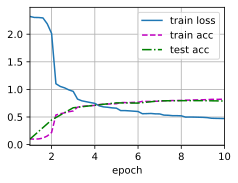

In [15]:
# 开始训练 
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 小结

* 卷积神经网络（CNN）是一类使用卷积层的网络。
* 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。
* 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
* 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
* LeNet是最早发布的卷积神经网络之一。